# Results
- Models used with hyperparameters: Bagging, Pasting, Random Forest, Ada Bost, Gradient Boost, XG Boost, Extra Trees, Voying Regressor, Stacking Regressor
- Best Model parameters Stacking Regressor (of 5 best models - gradient boost, XG boost, bagging with best model, pasting with best model, linear regression) with Lasso as final estimator {'n_jobs': -1, 'passthrough': False}
- Mean Cross validation score of Best model: 
  0.8984223135004216
- Test score of best model:
  test mse: 715427977.6424278,
  test rmse: 26747.485445223218,
  test r2: 0.8958940664117991
- Train score of best model:
  train mse: 328542371.5328516,
  train r2: 0.9473812911642712,


## Data PreProcessing

In [1]:
from math import sqrt
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats

pd.pandas.set_option('display.max_columns', None)
%matplotlib inline

### Load Datasets

In [2]:
# load dataset
# your code here
data = pd.read_csv(r'houseprice.csv')


### Types of variables



In [3]:
# we have an Id variable, that we should not use for predictions:

print('Number of House Id labels: ', len(data.Id.unique()))
print('Number of Houses in the Dataset: ', len(data))

Number of House Id labels:  1460
Number of Houses in the Dataset:  1460


#### Find categorical variables

In [4]:
# find categorical variables- hint data type = 'O'

categorical = [var for var in data.columns if data[var].dtype=='O']

print(f'There are {len(categorical)} categorical variables')

There are 43 categorical variables


#### Find temporal variables

In [5]:
# make a list of the numerical variables first= Hint data type != O
numerical = [var for var in data.columns if data[var].dtype!='O']

# list of variables that contain year information= Hint variable namme has Yr or 
year_vars = [var for var in numerical if 'Yr' in var or 'Year' in var]

year_vars

['YearBuilt', 'YearRemodAdd', 'GarageYrBlt', 'YrSold']

#### Find discrete variables

To identify discrete variables- numerical variables with less than 20 unique values 

In [6]:
# let's visualise the values of the discrete variables
discrete = [var for var in numerical if len(data[var].unique()) < 20 and var not in year_vars]

print(f'There are {len(discrete)} discrete variables')

There are 14 discrete variables


#### Continuous variables

In [7]:
# find continuous variables- hint numerical variables not in discrete and  year_years 
# Also remove the Id variable and the target variable SalePrice
# which are both also numerical

continuous = [var for var in numerical if var not in discrete and var not in [
    'Id', 'SalePrice'] and var not in year_vars]

print('There are {} numerical and continuous variables'.format(len(numerical)))

There are 38 numerical and continuous variables


### Separate train and test set

In [8]:
# Let's separate into train and test set
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(data.drop(['Id', 'SalePrice'], axis=1),
                                                    data['SalePrice'],
                                                    test_size=0.1,
                                                    random_state=0)

X_train.shape, X_test.shape

((1314, 79), (146, 79))

**Now we will move on and engineer the features of this dataset. The most important part for this course.**

### Craete New Variables

Replace 'YearBuilt', 'YearRemodAdd', 'GarageYrBlt  with time elapsed since YrSold
So YearBuilt = YrSold-YearBuilt. 

Similarly transform 'YearRemodAdd', 'GarageYrBlt.
After making transformation drop YrSold

In [9]:
# function to calculate elapsed time

def elapsed_years(df, var):
    # capture difference between year variable and
    # year the house was sold
    
    df[var] = df['YrSold'] - df[var]
    return df

In [10]:
for var in ['YearBuilt', 'YearRemodAdd', 'GarageYrBlt']:
    X_train = elapsed_years(X_train, var)
    X_test = elapsed_years(X_test, var)

In [11]:
# drop YrSold
X_train.drop('YrSold', axis=1, inplace=True)
X_test.drop('YrSold', axis=1, inplace=True)

In [12]:
year_vars.remove('YrSold')

In [13]:
# capture the column names for use later in the notebook
final_columns = X_train.columns
final_columns

Index(['MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street', 'Alley',
       'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope',
       'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle',
       'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'RoofStyle',
       'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'MasVnrArea',
       'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond',
       'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1', 'BsmtFinType2',
       'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating', 'HeatingQC',
       'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF',
       'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath',
       'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual', 'TotRmsAbvGrd',
       'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType', 'GarageYrBlt',
       'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual', 'GarageCond',
       'PavedDrive', 'Wo

### Feature Engineering Pipeline

In [14]:
# I will treat discrete variables as if they were categorical
# to treat discrete as categorical using Feature-engine
# we need to re-cast them as object

X_train[discrete] = X_train[discrete].astype('O')
X_test[discrete] = X_test[discrete].astype('O')

In [15]:
# import relevant modules for feature engineering
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from feature_engine import missing_data_imputers as mdi
from feature_engine import categorical_encoders as ce
from feature_engine.variable_transformers import YeoJohnsonTransformer
from sklearn.preprocessing import StandardScaler
from feature_engine.discretisers import DecisionTreeDiscretiser

In [16]:
house_preprocess = Pipeline([
    
    # missing data imputation 
    ('missing_ind', mdi.AddNaNBinaryImputer(
        variables=['LotFrontage', 'MasVnrArea',  'GarageYrBlt'])),
    ('imputer_num', mdi.MeanMedianImputer(imputation_method='mean',
                                          variables=['LotFrontage', 'MasVnrArea',  'GarageYrBlt'])),
    ('imputer_cat', mdi.CategoricalVariableImputer(variables=categorical)),

    # categorical encoding 
     ('rare_label_enc', ce.RareLabelCategoricalEncoder(
         tol=0.01,n_categories=6, variables=categorical+discrete)),
    ('categorical_enc', ce.MeanCategoricalEncoder(variables = categorical + discrete)),
     
    # Transforming Numerical Variables
    ('yjt', YeoJohnsonTransformer(variables = ['LotFrontage','MasVnrArea', 'GarageYrBlt'])),

    
    # discretisation and encoding
    ('treeDisc',  DecisionTreeDiscretiser(cv=2, scoring='neg_mean_squared_error',
                                   regression=True,
                                   param_grid={'max_depth': [1,2,3,4,5,6]})),

    # feature Scaling
    ('scaler', StandardScaler()),
    
    

])

In [17]:
house_preprocess.fit(X_train,y_train)

Pipeline(memory=None,
         steps=[('missing_ind',
                 AddNaNBinaryImputer(variables=['LotFrontage', 'MasVnrArea',
                                                'GarageYrBlt'])),
                ('imputer_num',
                 MeanMedianImputer(imputation_method='mean',
                                   variables=['LotFrontage', 'MasVnrArea',
                                              'GarageYrBlt'])),
                ('imputer_cat',
                 CategoricalVariableImputer(variables=['MSZoning', 'Street',
                                                       'Alley', 'LotShape',
                                                       'LandContour',
                                                       'Utilities', '...
                                                    'Utilities', 'LotConfig',
                                                    'LandSlope', 'Neighborhood',
                                                    'Condition1', 'Condition2',
    

In [18]:
# Apply Transformations
X_train=house_preprocess.transform(X_train)
X_test=house_preprocess.transform(X_test)

## <span class="mark">DO NOT CHANGE STEPS BEFORE THIS POINT</span>

## Regression Models- Tune different models one by one

In [19]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, r2_score
from math import sqrt

#Linear Regression
from sklearn.linear_model import LinearRegression
#Cross Validation
from sklearn.model_selection import cross_validate
from sklearn.model_selection import cross_val_score
#leave one out
from sklearn.model_selection import LeaveOneOut
#SGD
from sklearn.linear_model import SGDRegressor
#SGD with Grid Search and CV
from sklearn.model_selection import GridSearchCV
#Polynomial Features
from sklearn.preprocessing  import PolynomialFeatures
#Ridge, Lasso, ElasticNet
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
#KNN
from sklearn.neighbors import KNeighborsRegressor
#decision tree
from sklearn.tree import DecisionTreeRegressor
#SVM
from sklearn.svm import SVR,LinearSVR

In [20]:
#Different models and their pipelines

model_gs = Pipeline([
    ("regressor", LinearRegression())])
model_sgd=Pipeline([('scaler', MinMaxScaler()),("sgd_reg", SGDRegressor(max_iter=10000, tol = 1e-6))])
model_poly=Pipeline([('polynomialfeatures', PolynomialFeatures()),   
                     ('scaler',MinMaxScaler()),
                     ('norm_reg', LinearRegression())])
model_knn=Pipeline([ 
    ('scaler',MinMaxScaler()),
    ('knnreg', KNeighborsRegressor())])
model_decision_tree=Pipeline([("opt_tree",DecisionTreeRegressor(random_state = 0))])
model_svr = Pipeline([("svr", LinearSVR())])
model_svr_kern = Pipeline([("svr_kern", SVR())])

In [21]:
#Different hyperparameters for different models

model_parm_gd = [
    {'regressor': [LinearRegression()]},
    
    { 'regressor': [Ridge()],
      'regressor__alpha':[0.001, 0.01, 0.1, 1, 10, 100,200,300,400,500,700,1000] },
    
    {'regressor': [Lasso(random_state=0)],
      'regressor__alpha':[0.001, 0.01, 0.1, 1, 10, 100,200,750,800,900,1000]},
    
    {'regressor': [ElasticNet()],
      'regressor__alpha':[0.00001, 0.0001, 0.001, 0.01, 0.1, 1, 10], 'regressor__l1_ratio' :[0.2,0.4,0.6,0.8]}
]

model_sgd_parm=[
   { 'sgd_reg': [SGDRegressor()],
   'sgd_reg__eta0':[0.01, 0.05, 0.1 ,0.5] , 'sgd_reg__penalty' :['l1','l2'],'sgd_reg__alpha' :[0.1,0.01,0.001]
   },
   { 'sgd_reg': [SGDRegressor()],
    'sgd_reg__eta0':[0.01, 0.05, 0.1 ,0.5]}
]

model_poly_parm = {'polynomialfeatures__degree':range(1,3)}

model_knn_parm = {'knnreg__n_neighbors': range(1,25)}

model_dt_parm = {"opt_tree__max_depth": range(1,6),
           "opt_tree__min_samples_split": range(2,9),
           "opt_tree__max_leaf_nodes": range(2,8)}

model_svr_parm = [{'svr_kern': [SVR(kernel='rbf')], #36 combinations
               'svr_kern__C': [0.001, 0.01, 0.1, 1, 10, 100],
               'svr_kern__gamma': [0.001, 0.01, 0.1, 1, 10, 100],
                'svr_kern__epsilon': [0.001, 0.01, 0.1, 1]},
                  
              {'svr_kern': [SVR(kernel='linear')], #6 combinations
               'svr_kern__C': [0.001, 0.01, 0.1, 1, 10, 100]},
                  
                {'svr_kern': [SVR(kernel='poly')], #6 combinations
               'svr_kern__C': [0.001, 0.01, 0.1, 1, 10, 100],
                'svr_kern__gamma': [0.001, 0.01, 0.1, 1, 10, 100],
                'svr_kern__degree': [2,3]},
                  
                 {'svr_kern': [SVR(kernel='sigmoid')], #6 combinations
               'svr_kern__C': [0.001, 0.01, 0.1, 1, 10, 100],
                'svr_kern__gamma': [0.001, 0.01, 0.1, 1, 10, 100]}]

In [22]:
import warnings
warnings.filterwarnings("ignore")

#Linear Regression with regularization (lasso, ridge, elasticnet)

grid_search_housereg_pipe = GridSearchCV(model_gs, model_parm_gd,cv=5)
grid_search_housereg_pipe.fit(X_train,y_train)

#best cv score, best parameters, MSE train
print(grid_search_housereg_pipe.best_params_)
print(grid_search_housereg_pipe.best_score_)
X_train_predreg = grid_search_housereg_pipe.predict(X_train)
print('train mse: {}'.format(mean_squared_error(y_train, X_train_predreg)))

{'regressor': Lasso(alpha=750, copy_X=True, fit_intercept=True, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=0,
      selection='cyclic', tol=0.0001, warm_start=False), 'regressor__alpha': 750}
0.8854256400791181
train mse: 581954026.6972942


In [23]:
#SGD with and without regularization

grid_search_housesgd_pipe=GridSearchCV(model_sgd, model_sgd_parm,cv=5, n_jobs=-1, return_train_score = True)
grid_search_housesgd_pipe.fit(X_train,y_train)

#best cv score, best parameters, MSE train
print(grid_search_housesgd_pipe.best_params_)
print(grid_search_housesgd_pipe.best_score_)
X_train_predsgd = grid_search_housesgd_pipe.predict(X_train)
print('train mse: {}'.format(mean_squared_error(y_train, X_train_predsgd)))

{'sgd_reg': SGDRegressor(alpha=0.001, average=False, early_stopping=False, epsilon=0.1,
             eta0=0.05, fit_intercept=True, l1_ratio=0.15,
             learning_rate='invscaling', loss='squared_loss', max_iter=1000,
             n_iter_no_change=5, penalty='l2', power_t=0.25, random_state=None,
             shuffle=True, tol=0.001, validation_fraction=0.1, verbose=0,
             warm_start=False), 'sgd_reg__alpha': 0.001, 'sgd_reg__eta0': 0.05, 'sgd_reg__penalty': 'l2'}
0.8795179612484019
train mse: 649658611.3148422


In [24]:
#Polynomial regression with parameters

grid_search_housepoly_pipe=GridSearchCV(model_poly,model_poly_parm,cv=5, n_jobs=-1, return_train_score = True,scoring='neg_mean_squared_error')
grid_search_housepoly_pipe.fit(X_train,y_train)

#best cv score, best parameters, MSE train
print(grid_search_housepoly_pipe.best_params_)
print(grid_search_housepoly_pipe.best_score_)
X_train_predpoly = grid_search_housepoly_pipe.predict(X_train)
print('train mse: {}'.format(mean_squared_error(y_train, X_train_predpoly)))

{'polynomialfeatures__degree': 2}
-6.1136310956406974e+32
train mse: 27574.586567732116


In [25]:
#knn regression

grid_search_houseknn_pipe = GridSearchCV(model_knn, model_knn_parm, cv=5, return_train_score=True)
grid_search_houseknn_pipe.fit(X_train,y_train)

#best cv score, best parameters, MSE train
print(grid_search_houseknn_pipe.best_params_)
print(grid_search_houseknn_pipe.best_score_)
X_train_predknn = grid_search_houseknn_pipe.predict(X_train)
print('train mse: {}'.format(mean_squared_error(y_train, X_train_predknn)))

{'knnreg__n_neighbors': 6}
0.78587417331835
train mse: 926540858.0310757


In [26]:
#Decision Tree Regression

grid_search_housedt_pipe = GridSearchCV(model_decision_tree,model_dt_parm,cv=5)
grid_search_housedt_pipe.fit(X_train,y_train)

#best cv score, best parameters, MSE train
print(grid_search_housedt_pipe.best_params_)
print(grid_search_housedt_pipe.best_score_)
X_train_preddt = grid_search_housedt_pipe.predict(X_train)
print('train mse: {}'.format(mean_squared_error(y_train, X_train_preddt)))

{'opt_tree__max_depth': 4, 'opt_tree__max_leaf_nodes': 7, 'opt_tree__min_samples_split': 2}
0.6587712080710382
train mse: 1740418235.6455297


In [27]:
#LinearSVR
import warnings
warnings.filterwarnings("ignore")

model_svr.fit(X_train,y_train)
cv_scores_svc = cross_val_score(model_svr, X_train, y_train)
print("Mean Cross-validation scores: {}".format(cv_scores_svc.mean()))

Mean Cross-validation scores: -5.260634746826605


In [28]:
#Support Vector Machine - Kernel

grid_search_housesvr_pipe = GridSearchCV(model_svr_kern,model_svr_parm,cv=5)
grid_search_housesvr_pipe.fit(X_train,y_train)

#best cv score, best parameters, MSE train
print(grid_search_housesvr_pipe.best_params_)
print(grid_search_housesvr_pipe.best_score_)
X_train_predsvr = grid_search_housesvr_pipe.predict(X_train)
print('train mse: {}'.format(mean_squared_error(y_train, X_train_predsvr)))

{'svr_kern': SVR(C=100, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='scale',
    kernel='linear', max_iter=-1, shrinking=True, tol=0.001, verbose=False), 'svr_kern__C': 100}
0.8778845875884291
train mse: 666775306.6409111


In [29]:
#Using Lasso Regression at alpha value 750 to find test accuracy

X_test_predreg = grid_search_housereg_pipe.predict(X_test)
print('test mse: {}'.format(mean_squared_error(y_test, X_test_predreg)))
print('test rmse: {}'.format(sqrt(mean_squared_error(y_test, X_test_predreg))))
print('test r2: {}'.format(r2_score(y_test, X_test_predreg)))

print('train r2: {}'.format(r2_score(y_train, X_train_predreg)))

test mse: 788432890.199148
test rmse: 28079.04717398986
test r2: 0.8852707125372588
train r2: 0.9067953721046815


### HW3

In [30]:
#importing bagging regressor
from sklearn.ensemble import BaggingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import GradientBoostingRegressor
from xgboost import XGBRegressor
from sklearn.tree import ExtraTreeRegressor

In [31]:
best_model = Lasso(alpha=750)
model_bag_best = Pipeline([("bag_reg", BaggingRegressor(Lasso(alpha=750)))])
model_bag_dt = Pipeline([("bag_reg", BaggingRegressor(DecisionTreeRegressor(max_depth=4, max_leaf_nodes=7, min_samples_split=2,random_state = 0), bootstrap=True))])
model_pasting_best = Pipeline([("bag_reg", BaggingRegressor(Lasso(alpha=750), bootstrap=False))])
model_pasting_dt = Pipeline([("bag_reg", BaggingRegressor(DecisionTreeRegressor(max_depth=4, max_leaf_nodes=7, min_samples_split=2,random_state = 0), bootstrap=False))])
model_random_forest = Pipeline([("random_forest", RandomForestRegressor(n_jobs=-1, random_state=0))])

In [32]:
model_ada_dt = AdaBoostRegressor(DecisionTreeRegressor(max_depth=4, max_leaf_nodes=7, min_samples_split=2,random_state = 0),random_state=0)
model_ada_svr = AdaBoostRegressor(SVR(kernel='linear', C=100), random_state=0)
model_gbr = GradientBoostingRegressor()
model_xgboost = XGBRegressor()
model_etc = ExtraTreeRegressor(random_state=0)

In [44]:
bag_best_params = [
   {
    'bag_reg__n_estimators':[500] , 
    'bag_reg__max_samples' :[100,200,400,600]
   }
]

random_forest_params = [
    {
        'random_forest__n_estimators': [500],
        'random_forest__max_leaf_nodes': [10,30],
        'random_forest__max_features': [10,30,50],
        'random_forest__max_depth': [10,15,20]
    }
]

ada_boost_params = [
    {
        'n_estimators': [200],
        'learning_rate': [0.1,0.5,0.8,1,10]
    }
]

gbr_params = [
    {
        'max_depth': [2,4,6],
        'n_estimators': [200],
        'learning_rate': [0.01,0.1,1,10]
    }
]

xgboost_params = [
    {
        'learning_rate': [0.01,0.1],
        'max_depth': [2,4,6],
        'n_estimators': [500]
    }
]

etc_params = [
    {
        'criterion': ['mse', 'friedman_mse', 'mae'],
        'splitter': ['random', 'best'],
        'max_depth': [2,4,6],
        'max_features': ['auto', 'sqrt', 'log2'],
    }
]

In [34]:
#Bagging with lasso alpha = 750

grid_search_bag = GridSearchCV(model_bag_best,bag_best_params, cv=5)
grid_search_bag.fit(X_train,y_train)

#best cv score, best parameters, MSE train
print(grid_search_bag.best_params_)
print(grid_search_bag.best_score_)
X_train_pred = grid_search_bag.predict(X_train)
print('train mse: {}'.format(mean_squared_error(y_train, X_train_pred)))
print('train r2: {}'.format(r2_score(y_train, X_train_pred)))
x_testpred = grid_search_bag.predict(X_test)
print('test mse: {}'.format(mean_squared_error(y_test, x_testpred)))
print('test rmse: {}'.format(sqrt(mean_squared_error(y_test, x_testpred))))
print('test r2: {}'.format(r2_score(y_test, x_testpred)))

{'bag_reg__max_samples': 100, 'bag_reg__n_estimators': 500}
0.8886642071963831
train mse: 631988848.1816771
train r2: 0.8987818921658507
test mse: 880190130.6181058
test rmse: 29667.99842621854
test r2: 0.8719186023657064


In [35]:
#bagging with decision tree

grid_search_bag_dt = GridSearchCV(model_bag_dt,bag_best_params, cv=5)
grid_search_bag_dt.fit(X_train,y_train)

#best cv score, best parameters, MSE train
print(grid_search_bag_dt.best_params_)
print(grid_search_bag_dt.best_score_)
X_train_pred = grid_search_bag_dt.predict(X_train)
print('train mse: {}'.format(mean_squared_error(y_train, X_train_pred)))
print('train r2: {}'.format(r2_score(y_train, X_train_pred)))
x_testpred = grid_search_bag_dt.predict(X_test)
print('test mse: {}'.format(mean_squared_error(y_test, x_testpred)))
print('test rmse: {}'.format(sqrt(mean_squared_error(y_test, x_testpred))))
print('test r2: {}'.format(r2_score(y_test, x_testpred)))

{'bag_reg__max_samples': 100, 'bag_reg__n_estimators': 500}
0.7996634242055343
train mse: 1162255429.7249367
train r2: 0.8138554252101202
test mse: 1622573227.781437
test rmse: 40281.17709031647
test r2: 0.7638902783057875


In [36]:
# pasting with best model lasso alpha = 750

grid_search_pasting = GridSearchCV(model_pasting_best,bag_best_params, cv=5)
grid_search_pasting.fit(X_train,y_train)

#best cv score, best parameters, MSE train
print(grid_search_pasting.best_params_)
print(grid_search_pasting.best_score_)
X_train_pred = grid_search_pasting.predict(X_train)
print('train mse: {}'.format(mean_squared_error(y_train, X_train_pred)))
print('train r2: {}'.format(r2_score(y_train, X_train_pred)))
x_testpred = grid_search_pasting.predict(X_test)
print('test mse: {}'.format(mean_squared_error(y_test, x_testpred)))
print('test rmse: {}'.format(sqrt(mean_squared_error(y_test, x_testpred))))
print('test r2: {}'.format(r2_score(y_test, x_testpred)))

{'bag_reg__max_samples': 200, 'bag_reg__n_estimators': 500}
0.8876003789738238
train mse: 600284956.7546918
train r2: 0.9038595259096289
test mse: 855788152.7335391
test rmse: 29253.85705737859
test r2: 0.8754694708926025


In [37]:
#pasting with decision tree

grid_search_pasting_dt = GridSearchCV(model_pasting_dt,bag_best_params, cv=5)
grid_search_pasting_dt.fit(X_train,y_train)

#best cv score, best parameters, MSE train
print(grid_search_pasting_dt.best_params_)
print(grid_search_pasting_dt.best_score_)
X_train_pred = grid_search_pasting_dt.predict(X_train)
print('train mse: {}'.format(mean_squared_error(y_train, X_train_pred)))
print('train r2: {}'.format(r2_score(y_train, X_train_pred)))
x_testpred = grid_search_pasting_dt.predict(X_test)
print('test mse: {}'.format(mean_squared_error(y_test, x_testpred)))
print('test rmse: {}'.format(sqrt(mean_squared_error(y_test, x_testpred))))
print('test r2: {}'.format(r2_score(y_test, x_testpred)))

{'bag_reg__max_samples': 100, 'bag_reg__n_estimators': 500}
0.7981706756364672
train mse: 1136810361.9047039
train r2: 0.8179306579074782
test mse: 1572748103.6708734
test rmse: 39657.88829061468
test r2: 0.771140611286574


In [38]:
#Random Forest

grid_search_rf = GridSearchCV(model_random_forest,random_forest_params, cv=5)
grid_search_rf.fit(X_train,y_train)

#best cv score, best parameters, MSE train
print(grid_search_rf.best_params_)
print(grid_search_rf.best_score_)
X_train_pred = grid_search_rf.predict(X_train)
print('train mse: {}'.format(mean_squared_error(y_train, X_train_pred)))
print('train r2: {}'.format(r2_score(y_train, X_train_pred)))
x_testpred = grid_search_rf.predict(X_test)
print('test mse: {}'.format(mean_squared_error(y_test, x_testpred)))
print('test rmse: {}'.format(sqrt(mean_squared_error(y_test, x_testpred))))
print('test r2: {}'.format(r2_score(y_test, x_testpred)))

{'random_forest__max_depth': 15, 'random_forest__max_features': 30, 'random_forest__max_leaf_nodes': 30, 'random_forest__n_estimators': 500}
0.8592041145606235
train mse: 522789102.89559275
train r2: 0.9162711115177896
test mse: 949245466.0987024
test rmse: 30809.827427278822
test r2: 0.8618699735810951


In [39]:
#Ada Boost Decision Tree

grid_search_ada_dt = GridSearchCV(model_ada_dt,ada_boost_params, cv=5)
grid_search_ada_dt.fit(X_train,y_train)

#best cv score, best parameters, MSE train
print(grid_search_ada_dt.best_params_)
print(grid_search_ada_dt.best_score_)
X_train_pred = grid_search_ada_dt.predict(X_train)
print('train mse: {}'.format(mean_squared_error(y_train, X_train_pred)))
print('train r2: {}'.format(r2_score(y_train, X_train_pred)))
x_testpred =grid_search_ada_dt.predict(X_test)
print('test mse: {}'.format(mean_squared_error(y_test, x_testpred)))
print('test rmse: {}'.format(sqrt(mean_squared_error(y_test, x_testpred))))
print('test r2: {}'.format(r2_score(y_test, x_testpred)))

{'learning_rate': 0.5, 'n_estimators': 200}
0.8010113763601057
train mse: 816967355.8050702
train r2: 0.869156093252636
test mse: 1070424584.7927455
test rmse: 32717.34379182921
test r2: 0.8442365210501906


In [40]:
#Ada Boost SVR
grid_search_ada_svr = GridSearchCV(model_ada_svr,ada_boost_params, cv=5)
grid_search_ada_svr.fit(X_train,y_train)

#best cv score, best parameters, MSE train
print(grid_search_ada_svr.best_params_)
print(grid_search_ada_svr.best_score_)
X_train_pred = grid_search_ada_svr.predict(X_train)
print('train mse: {}'.format(mean_squared_error(y_train, X_train_pred)))
print('train r2: {}'.format(r2_score(y_train, X_train_pred)))
x_testpred =grid_search_ada_svr.predict(X_test)
print('test mse: {}'.format(mean_squared_error(y_test, x_testpred)))
print('test rmse: {}'.format(sqrt(mean_squared_error(y_test, x_testpred))))
print('test r2: {}'.format(r2_score(y_test, x_testpred)))

{'learning_rate': 0.1, 'n_estimators': 200}
0.8349696353247023
train mse: 673031784.6023625
train r2: 0.8922085350941056
test mse: 1149539679.9780738
test rmse: 33904.86218786435
test r2: 0.8327240402658502


In [41]:
#Gradient Boost

grid_search_gbr = GridSearchCV(model_gbr,gbr_params, cv=5)
grid_search_gbr.fit(X_train,y_train)

#best cv score, best parameters, MSE train
print(grid_search_gbr.best_params_)
print(grid_search_gbr.best_score_)
X_train_pred = grid_search_gbr.predict(X_train)
print('train mse: {}'.format(mean_squared_error(y_train, X_train_pred)))
print('train r2: {}'.format(r2_score(y_train, X_train_pred)))
x_testpred =grid_search_gbr.predict(X_test)
print('test mse: {}'.format(mean_squared_error(y_test, x_testpred)))
print('test rmse: {}'.format(sqrt(mean_squared_error(y_test, x_testpred))))
print('test r2: {}'.format(r2_score(y_test, x_testpred)))

{'learning_rate': 0.1, 'max_depth': 2, 'n_estimators': 200}
0.8926108164366567
train mse: 310508067.4508798
train r2: 0.9502696303185693
test mse: 826310514.6465408
test rmse: 28745.617311975417
test r2: 0.8797589271746098


In [42]:
#Xboost

grid_search_xgb = GridSearchCV(model_xgboost,xgboost_params, cv=5)
grid_search_xgb.fit(X_train,y_train)

#best cv score, best parameters, MSE train
print(grid_search_xgb.best_params_)
print(grid_search_xgb.best_score_)
X_train_pred = grid_search_xgb.predict(X_train)
print('train mse: {}'.format(mean_squared_error(y_train, X_train_pred)))
print('train r2: {}'.format(r2_score(y_train, X_train_pred)))
x_testpred =grid_search_xgb.predict(X_test)
print('test mse: {}'.format(mean_squared_error(y_test, x_testpred)))
print('test rmse: {}'.format(sqrt(mean_squared_error(y_test, x_testpred))))
print('test r2: {}'.format(r2_score(y_test, x_testpred)))

{'learning_rate': 0.1, 'max_depth': 2, 'n_estimators': 500}
0.8924888852513666
train mse: 228450778.96277493
train r2: 0.9634117664474955
test mse: 730919782.1334028
test rmse: 27035.528146004523
test r2: 0.8936397671393365


In [45]:
#Extra Tree Regressor

grid_search_etc = GridSearchCV(model_etc,etc_params, cv=5)
grid_search_etc.fit(X_train,y_train)

#best cv score, best parameters, MSE train
print(grid_search_etc.best_params_)
print(grid_search_etc.best_score_)
X_train_pred = grid_search_etc.predict(X_train)
print('train mse: {}'.format(mean_squared_error(y_train, X_train_pred)))
print('train r2: {}'.format(r2_score(y_train, X_train_pred)))
x_testpred =grid_search_etc.predict(X_test)
print('test mse: {}'.format(mean_squared_error(y_test, x_testpred)))
print('test rmse: {}'.format(sqrt(mean_squared_error(y_test, x_testpred))))
print('test r2: {}'.format(r2_score(y_test, x_testpred)))

{'criterion': 'mse', 'max_depth': 6, 'max_features': 'auto', 'splitter': 'random'}
0.7613424652480048
train mse: 704749667.5247215
train r2: 0.8871286604995727
test mse: 1202053249.840322
test rmse: 34670.6395937589
test r2: 0.8250824964803052


In [47]:
regressors={'linreg':grid_search_housereg_pipe ,
             'sgd':grid_search_housesgd_pipe,
             'poly':grid_search_housepoly_pipe,
             'knn': grid_search_houseknn_pipe,
             'dtree':grid_search_housedt_pipe,
             'svrkernel':grid_search_housesvr_pipe,
             'bag_best':grid_search_bag,
             'bag_dtree':grid_search_bag_dt,
             'paste_best':grid_search_pasting,
             'paste_dtree':grid_search_pasting_dt,
             'rfc': grid_search_rf,
             'etc': grid_search_etc,
             'adc_dtree':grid_search_ada_dt,
             'ada_svr': grid_search_ada_svr,
             'gbc': grid_search_gbr,
             'xgbc': grid_search_xgb,
           }

In [48]:
regressors.keys()

dict_keys(['linreg', 'sgd', 'poly', 'knn', 'dtree', 'svrkernel', 'bag_best', 'bag_dtree', 'paste_best', 'paste_dtree', 'rfc', 'etc', 'adc_dtree', 'ada_svr', 'gbc', 'xgbc'])

In [50]:
results_mean_std = []
for  key, value in regressors.items():
    mean = value.cv_results_['mean_test_score'][value.best_index_]
    std=value.cv_results_['std_test_score'][value.best_index_]
     
    results_mean_std.append({
        "model": key,
        "mean": mean,
        "std": std
    })

In [51]:
# Create a Pandas DataFrame with the mean+std results
R2_df = pd.DataFrame(results_mean_std, columns=['model', 'mean', 'std'])

In [52]:
# Show the accuracy dataframe

R2_df.sort_values(by=['mean'], inplace=True,ascending=False)
R2_df

,model,mean,std
14,gbc,8.926108e-01,1.060201e-02
15,xgbc,8.924889e-01,2.184404e-02
6,bag_best,8.886642e-01,9.896032e-03
8,paste_best,8.876004e-01,8.254707e-03
0,linreg,8.854256e-01,7.152564e-03
1,sgd,8.795180e-01,1.426131e-02
5,svrkernel,8.778846e-01,8.926488e-03
10,rfc,8.592041e-01,1.592986e-02
13,ada_svr,8.349696e-01,2.500796e-02
12,adc_dtree,8.010114e-01,1.509580e-02


In [54]:
# Create a prediction of all models on the test set
predictions_all = {}
for  key, value in regressors.items():
    # Get best estimator
    best_model = value.best_estimator_
    
    # Predict test labels
    predictions = best_model.predict(X_test)
    
    # Save predictions to a list
    predictions_all[key] = predictions

In [55]:
# Creat a DataFrame for the predictions
pred = pd.DataFrame(predictions_all)

Text(0.5, 1, 'Correlation of the test set label prediction between models')

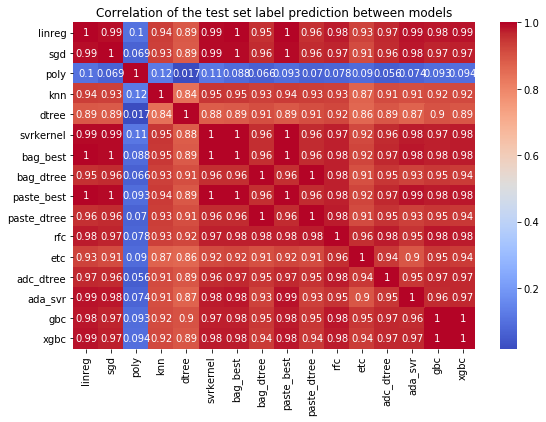

In [56]:
# Plot a heatmap of all correlations for easier visualization
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(9,6))
g = sns.heatmap(pred.corr(), annot=True, cmap='coolwarm', ax=ax)
g.set_title('Correlation of the test set label prediction between models')

In [57]:
def get_redundant_pairs(df):
    '''Get diagonal and lower triangular pairs of correlation matrix'''
    pairs_to_drop = set()
    cols = df.columns
    for i in range(0, df.shape[1]):
        for j in range(0, i+1):
            pairs_to_drop.add((cols[i], cols[j]))
    return pairs_to_drop

def get_top_abs_correlations(df, n=5):
    au_corr = df.corr().abs().unstack()
    labels_to_drop = get_redundant_pairs(df)
    au_corr = au_corr.drop(labels=labels_to_drop).sort_values(ascending=True)
    return au_corr[0:n]



In [58]:
print("Least Absolute Correlations")
print(get_top_abs_correlations(pred, 5))

Least Absolute Correlations
poly  dtree          0.017446
      adc_dtree      0.056123
      bag_dtree      0.066492
sgd   poly           0.068565
poly  paste_dtree    0.069950
dtype: float64


In [67]:
#Top 5 best models - XGboost, Gradient Boost, Bagging with Lasso (best model), Pasting with Lasso (best model), Linear Regression
from sklearn.ensemble import VotingRegressor

vclf1 = VotingRegressor(estimators=
                              [('gbc', grid_search_gbr.best_estimator_), 
                               ('xgbc', grid_search_xgb.best_estimator_), 
                               ('bag_best', grid_search_bag.best_estimator_),
                               ('paste_best', grid_search_pasting.best_estimator_),
                               ('linreg', grid_search_housereg_pipe.best_estimator_)
                              ], )
vclf1_param = {
              'n_jobs' : [-1,1]
             }
voting_best5 = GridSearchCV(vclf1, vclf1_param,cv=5 )
voting_best5.fit(X_train,y_train)

#best cv score, best parameters, MSE train
print(voting_best5.best_params_)
print(voting_best5.best_score_)
X_trainvt = voting_best5.predict(X_train)
print('train mse: {}'.format(mean_squared_error(y_train, X_trainvt)))
print('train r2: {}'.format(r2_score(y_train, X_trainvt)))
x_testvt =voting_best5.predict(X_test)
print('test mse: {}'.format(mean_squared_error(y_test, x_testvt)))
print('test rmse: {}'.format(sqrt(mean_squared_error(y_test, x_testvt))))
print('test r2: {}'.format(r2_score(y_test, x_testvt)))

{'n_jobs': -1}
0.8976522947122468
train mse: 405322011.68574876
train r2: 0.9350844129538046
test mse: 738758631.0286127
test rmse: 27180.114625008715
test r2: 0.8924990923153214


In [68]:
#5 least correlated models - Polynomial, Decision Tree, Ada bosst with decision tree, bagging with decision tree, sgd, pasting with decision tree

vclf2 = VotingRegressor(estimators=
                              [('poly', grid_search_housepoly_pipe.best_estimator_), 
                               ( 'dtree',grid_search_housedt_pipe.best_estimator_), 
                               ('adc_dtree',grid_search_ada_dt.best_estimator_),
                               ('bag_dtree',grid_search_bag_dt.best_estimator_),
                               ('sgd',grid_search_housesgd_pipe.best_estimator_)
                              ], )
vclf2_param = {
              'n_jobs' : [-1,1]
             }
voting_least5 = GridSearchCV(vclf2, vclf2_param,cv=5 )
voting_least5.fit(X_train,y_train)

#best cv score, best parameters, MSE train
print(voting_least5.best_params_)
print(voting_least5.best_score_)
X_trainvt = voting_least5.predict(X_train)
print('train mse: {}'.format(mean_squared_error(y_train, X_trainvt)))
print('train r2: {}'.format(r2_score(y_train, X_trainvt)))
x_testvt =voting_least5.predict(X_test)
print('test mse: {}'.format(mean_squared_error(y_test, x_testvt)))
print('test rmse: {}'.format(sqrt(mean_squared_error(y_test, x_testvt))))
print('test r2: {}'.format(r2_score(y_test, x_testvt)))

{'n_jobs': 1}
-9.637074847832025e+20
train mse: 494762856.152841
train r2: 0.9207597408237593
test mse: 6.266596746972778e+28
test rmse: 250331714869945.66
test r2: -9.118876045555614e+18


In [72]:
#Stacking with 5 best models 

from sklearn.ensemble import StackingRegressor

#Stacking Top 5
sclf1 = StackingRegressor(estimators=
                              [('gbc', grid_search_gbr.best_estimator_), 
                               ('xgbc', grid_search_xgb.best_estimator_), 
                               ('bag_best', grid_search_bag.best_estimator_),
                               ('paste_best', grid_search_pasting.best_estimator_),
                               ('linreg', grid_search_housereg_pipe.best_estimator_)
                              ], final_estimator=Lasso())
sclf1_param = {
              'n_jobs': [1,-1],
              'passthrough': [True, False]
             }
sclf1_grid = GridSearchCV(sclf1, sclf1_param,cv=5, return_train_score=True, )
sclf1_grid.fit(X_train,y_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=StackingRegressor(cv=None,
                                         estimators=[('gbc',
                                                      GradientBoostingRegressor(alpha=0.9,
                                                                                ccp_alpha=0.0,
                                                                                criterion='friedman_mse',
                                                                                init=None,
                                                                                learning_rate=0.1,
                                                                                loss='ls',
                                                                                max_depth=2,
                                                                                max_features=None,
                                                                                max_leaf

In [73]:
#best cv score, best parameters, MSE train
print(sclf1_grid.best_params_)
print(sclf1_grid.best_score_)
X_trainvt = sclf1_grid.predict(X_train)
print('train mse: {}'.format(mean_squared_error(y_train, X_trainvt)))
print('train r2: {}'.format(r2_score(y_train, X_trainvt)))
x_testvt =sclf1_grid.predict(X_test)
print('test mse: {}'.format(mean_squared_error(y_test, x_testvt)))
print('test rmse: {}'.format(sqrt(mean_squared_error(y_test, x_testvt))))
print('test r2: {}'.format(r2_score(y_test, x_testvt)))

{'n_jobs': -1, 'passthrough': False}
0.8984223135004216
train mse: 328542371.5328516
train r2: 0.9473812911642712
test mse: 715427977.6424278
test rmse: 26747.485445223218
test r2: 0.8958940664117991


In [74]:
#Stacking with least 5 correlated

from sklearn.ensemble import StackingRegressor

#Stacking Top 5
sclf2 = StackingRegressor(estimators=
                              [('poly', grid_search_housepoly_pipe.best_estimator_), 
                               ( 'dtree',grid_search_housedt_pipe.best_estimator_), 
                               ('adc_dtree',grid_search_ada_dt.best_estimator_),
                               ('bag_dtree',grid_search_bag_dt.best_estimator_),
                               ('sgd',grid_search_housesgd_pipe.best_estimator_)
                              ], final_estimator=Lasso())
sclf2_param = {
              'n_jobs': [1,-1],
              'passthrough': [True, False]
             }
sclf2_grid = GridSearchCV(sclf2, sclf2_param,cv=5, return_train_score=True, )
sclf2_grid.fit(X_train,y_train)

#best cv score, best parameters, MSE train
print(sclf2_grid.best_params_)
print(sclf2_grid.best_score_)
X_trainvt = sclf2_grid.predict(X_train)
print('train mse: {}'.format(mean_squared_error(y_train, X_trainvt)))
print('train r2: {}'.format(r2_score(y_train, X_trainvt)))
x_testvt =sclf2_grid.predict(X_test)
print('test mse: {}'.format(mean_squared_error(y_test, x_testvt)))
print('test rmse: {}'.format(sqrt(mean_squared_error(y_test, x_testvt))))
print('test r2: {}'.format(r2_score(y_test, x_testvt)))

{'n_jobs': 1, 'passthrough': True}
0.864444668174789
train mse: 889732192.991633
train r2: 0.8575022180963348
test mse: 942817105.4447632
test rmse: 30705.326988077544
test r2: 0.8628054003581207


In [77]:
#Stacking with least 2 correlated


sclf3 = StackingRegressor(estimators=
                              [('poly', grid_search_housepoly_pipe.best_estimator_), 
                               ( 'dtree',grid_search_housedt_pipe.best_estimator_), 
                               ('adc_dtree',grid_search_ada_dt.best_estimator_),
                               ('bag_dtree',grid_search_bag_dt.best_estimator_),
                               ('sgd',grid_search_housesgd_pipe.best_estimator_)
                              ], final_estimator=XGBRegressor())
sclf3_param = {
                 'final_estimator__learning_rate': [0.01,0.1],
                'final_estimator__max_depth': [2,4,6],
               'final_estimator__n_estimators': [500]
             }

sclf3_grid = GridSearchCV(sclf3, sclf3_param,cv=5, return_train_score=True, )
sclf3_grid.fit(X_train,y_train)

#best cv score, best parameters, MSE train
print(sclf3_grid.best_params_)
print(sclf3_grid.best_score_)
X_trainvt = sclf3_grid.predict(X_train)
print('train mse: {}'.format(mean_squared_error(y_train, X_trainvt)))
print('train r2: {}'.format(r2_score(y_train, X_trainvt)))
x_testvt =sclf3_grid.predict(X_test)
print('test mse: {}'.format(mean_squared_error(y_test, x_testvt)))
print('test rmse: {}'.format(sqrt(mean_squared_error(y_test, x_testvt))))
print('test r2: {}'.format(r2_score(y_test, x_testvt)))

{'final_estimator__learning_rate': 0.01, 'final_estimator__max_depth': 2, 'final_estimator__n_estimators': 500}
0.8712809541105914
train mse: 566237098.0112711
train r2: 0.909312564911391
test mse: 822724845.4179257
test rmse: 28683.180531766797
test r2: 0.8802806979946629
